# Text classification with the torchtext library

Based on the tutorial: https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

```
pip install -U portalocker>=2.0.0
```

In [ ]:
NAME = 'text_sentiment_ngrams'
SAVE_PATH = f'data/test/train/{NAME}-checkpoint.pth'
REPORT_PATH = f'data/test/train/{NAME}-report.pdf'
ROOT_DIR = 'data/ag_news'

In [1]:
import sys
if "../" not in sys.path:
  sys.path.append("../")

In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

### Access to the raw dataset iterators

In [3]:
import torch
import typing
from torchtext.datasets import AG_NEWS

iterable: typing.Any = AG_NEWS(root=ROOT_DIR, split="train")
train_iter = iter(iterable)

In [4]:
next(train_iter)

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

### Prepare data processing pipelines

In [5]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")
train_iter = AG_NEWS(root=ROOT_DIR, split="train")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [6]:
vocab(['here', 'is', 'an', 'example'])

[475, 21, 30, 5297]

In [7]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [8]:
text_pipeline('here is the an example')

[475, 21, 2, 30, 5297]

In [9]:
label_pipeline('10')

9

### Generate data batch and iterator

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list = [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    return text_list, label_list

### Define the model

In [11]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

### Initiate an instance

In [12]:
train_iter = AG_NEWS(root=ROOT_DIR, split="train")
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

### Split the dataset

In [13]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader

BATCH_SIZE = 64  # batch size for training

train_iter, test_iter = AG_NEWS(root=ROOT_DIR, split=('train', 'test')) # type: ignore
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader: DataLoader[tuple[list[torch.Tensor], torch.Tensor]] = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader: DataLoader[tuple[list[torch.Tensor], torch.Tensor]] = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader: DataLoader[tuple[list[torch.Tensor], torch.Tensor]] = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

### Define the Manager

In [14]:
from synth_mind import supervised
from synth_mind.supervised.handlers import MaxProbEvaluator, GeneralBatchAccuracyCalculator, BatchExecutor, BatchExecutorParams
from lib.metrics import MainMetrics

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.1)

class MyBatchExecutor(BatchExecutor[list[torch.Tensor], torch.Tensor]):
    def run(self, params: BatchExecutorParams[list[torch.Tensor], torch.Tensor]) -> torch.Tensor:
        model = params.model
        text_list = params.input
        texts_cat = torch.cat(text_list)
        all_offsets = [0] + [len(text) for text in text_list]
        offsets = torch.tensor(all_offsets[:-1]).cumsum(dim=0)
        predicted_label = model(texts_cat, offsets)
        return predicted_label

    def main_output(self, output: typing.Any) -> typing.Any:
        return output

manager = supervised.Manager(
    data_params=supervised.ManagerDataParams(
        train_dataloader=train_dataloader,
        validation_dataloader=valid_dataloader,
        test_dataloader=test_dataloader,
    ),
    model_params=supervised.ManagerModelParams(
        model=model,
        criterion=criterion,
        executor=MyBatchExecutor(),
        use_best=False,
        clip_grad_max=0.1,
    ),
    optimizer_params=supervised.ManagerOptimizerParams(
        optimizer=optimizer,
        scheduler=scheduler,
        step_only_on_accuracy_loss=True,
    ),
    metrics_params=supervised.ManagerMetricsParams(
        evaluator=MaxProbEvaluator(executor=MyBatchExecutor()),
        accuracy_calculator=GeneralBatchAccuracyCalculator(),
        metrics_calculator=MainMetrics(name=NAME).as_file_plotter(REPORT_PATH, figsize=(8, 8)),
        batch_interval=True,
        default_interval=500,
    ),
    config=supervised.ManagerConfig(
        save_path=SAVE_PATH,
        random_seed=0,
    ),
)

### Run the model (training + validation + test)

Starting training for 10 epochs...
> [train] [epoch 1 ( 10.0%)] [batch:  500/1782] [time:   0m 13.20s] [accuracy:  68.5%] [loss: 0.0128]
> [train] [epoch 1 ( 10.0%)] [batch: 1000/1782] [time:   0m 28.56s] [accuracy:  85.5%] [loss: 0.0067]
> [train] [epoch 1 ( 10.0%)] [batch: 1500/1782] [time:   0m 41.91s] [accuracy:  87.4%] [loss: 0.0059]
> [train] [epoch 1 ( 10.0%)] [batch: 1782/1782] [time:   0m 49.37s] [accuracy:  88.3%] [loss: 0.0054]
------------------------------------------------------------------------------------------------------
> [validation] [epoch 1 ( 10.0%)] [batch: 94/94] [time:    0m 0.39s] [accuracy:  89.0%] [loss: 0.0052]
---------------------------------------------------------------------------------------------------------------------------------------------------
[end of epoch 1 ( 10.0%)] [time:   0m 49.84s (-   7m 28.58s)] [val_accuracy:  89.0%, train_accuracy:  81.7%] [val_loss: 0.0052, train_loss: 0.0080]
> [train] [epoch 2 ( 20.0%)] [batch:  500/1782] [time: 

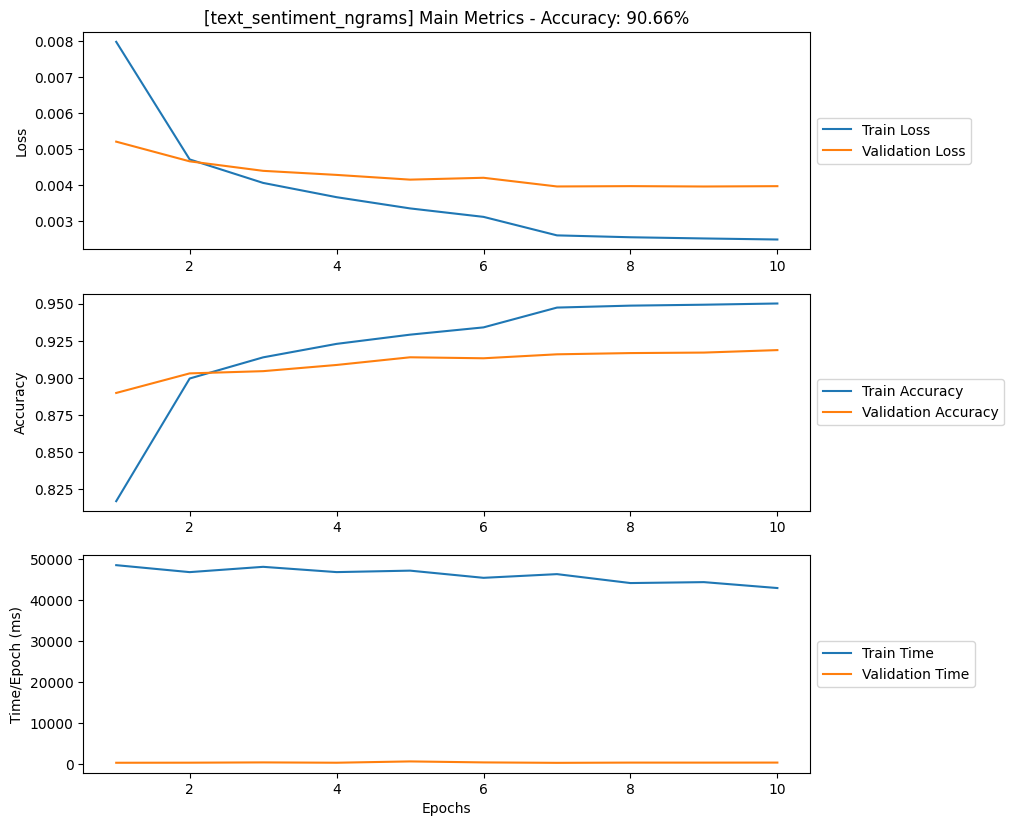

In [15]:
manager.train(epochs=10)

### Test on a random news

In [31]:
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}

model = model.to("cpu")

def predict(text: str, text_pipeline: typing.Callable[[str], typing.Any]) -> int:
    with torch.no_grad():
        text_tensor = torch.tensor(text_pipeline(text))
        result = manager.evaluate([text_tensor])
        _, label = result.prediction
        return label + 1

In [32]:
# Sports example
ex_text_str = "MEMPHIS, Tenn. - Four days ago, Jon Rahm was \
    enduring the season's worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday's first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he'd never played the \
    front nine at TPC Southwind."

print("This is a %s news" % ag_news_label[predict(ex_text_str, text_pipeline)])

This is a Sports news


In [33]:
# Business example
ex_text_str = "Intel Corp. on Thursday reported second-quarter profit of $5.06 billion."

print("This is a %s news" % ag_news_label[predict(ex_text_str, text_pipeline)])

This is a Business news


In [34]:
# Sci/Tec example
ex_text_str = "The U.S. Department of Commerce is set to announce a new set of regulations on Wednesday that are aimed at limiting exports of specific technologies to China."

print("This is a %s news" % ag_news_label[predict(ex_text_str, text_pipeline)])

This is a Sci/Tec news


In [35]:
# World example
ex_text_str = "In Oceania, there are only four countries, with the biggest being Australia."

print("This is a %s news" % ag_news_label[predict(ex_text_str, text_pipeline)])

This is a World news
